In [29]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [30]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

###**Load dataset**

In [1]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (39/39), 186.94 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

In [3]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [4]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

###**Preprocessing**
- Remove non-Vietnamese comment
- "Clean" data
  - Remove HTML, URL
  - Remove special character, emoji,...
  - Convert to lower case
  - ...

In [5]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=9d87a6523a1412b62e89c12431534ba254deb317017a2de29f99158d828fe3ad
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid


In [6]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [7]:
train_df_vi, train_df_other = identify_vn(train_df)

In [8]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [9]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

<ipython-input-9-e21d2b59a2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [10]:
train_df_vi

,sentence,label,preprocess_sentence
0,Phong_cách quán này lạ mà thích cực luôn . Khô...,1,phong cách quán này lạ mà thích cực luôn không...
1,Có cảm_giác bột trà xanh của starbucks dùng lo...,1,có cảm giác bột trà xanh của starbucks dùng lo...
2,Mình và vài người bạn đã ăn bánh ở đây và đều ...,1,mình và vài người bạn đã ăn bánh ở đây và đều ...
3,Quán nhỏ nhưng ngồi rất thoải_mái . Thức uống ...,1,quán nhỏ nhưng ngồi rất thoải mái thức uống gi...
4,Ăn cái đầu_tiên rất ngon . Cái thứ 2 cũng ngon...,1,ăn cái đầu tiên rất ngon cái thứ cũng ngon ăn ...
...,...,...,...
29995,"Quán hơi bé , mà hình_như chỉ mở vào buổi tối ...",0,quán hơi bé mà hình như chỉ mở vào buổi tối có...
29996,Chả hiểu nhân_viên làm_ăn kiểu gì ? ? mua 5 mi...,0,chả hiểu nhân viên làm ăn kiểu gì mua miếng mự...
29997,Mình đi đây cùng đồng_nghiệp có sử_dụng vouche...,0,mình đi đây cùng đồng nghiệp có sử dụng vouche...
29998,"Vừa choén xong . quẩy đùi gà hơi dai , sữa_chu...",0,vừa choén xong quẩy đùi gà hơi dai sữa chua nh...


###**Vectorize data**

In [11]:
!pip install torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.1.0.70
    Uninstalling nvidia-cudnn-cu12-9.1.0.70:
      Successfully uninstalled nvi

In [12]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [13]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [14]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [15]:
vocabulary["<pad>"]

0

In [16]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

###**Dataloader**

In [17]:
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [18]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [19]:
next(iter(train_dataloader))

(tensor([[ 38,   7,   7,  ...,   7,   6, 737],
         [ 20, 228,  94,  ...,  48,  60, 145],
         [395, 159, 238,  ...,  40, 262,  45],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]),
 tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
         0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
         1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
         1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
         0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
         0, 1, 0, 1, 0, 0, 1, 0]))

In [20]:
encoded_sentences, labels = next(iter(train_dataloader))

In [21]:
encoded_sentences.shape

torch.Size([668, 128])

###**Build model**

In [22]:
import torch.nn as nn
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

In [23]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [24]:
vocab_size

10000

In [31]:
predictions = model(encoded_sentences)
predictions

tensor([[-0.1592, -1.0468],
        [-0.1112, -1.0832],
        [ 0.0713, -1.1609],
        [-0.2816, -1.0665],
        [-0.2495, -0.8053],
        [-0.2272, -0.8906],
        [-0.2164, -1.1727],
        [-0.1406, -0.7782],
        [-0.1534, -0.8860],
        [ 0.0187, -0.7454],
        [-0.2202, -0.7519],
        [ 0.0426, -1.0770],
        [-0.0035, -1.0429],
        [-0.1604, -1.1642],
        [-0.4310, -1.0967],
        [-0.1583, -1.0341],
        [-0.0584, -0.9610],
        [-0.1037, -1.0834],
        [-0.2710, -0.9350],
        [-0.2746, -1.0675],
        [ 0.0166, -1.3270],
        [-0.0210, -0.7355],
        [-0.0025, -0.9729],
        [-0.0321, -0.7800],
        [-0.1186, -1.0619],
        [-0.2355, -0.9057],
        [-0.4488, -0.7279],
        [-0.0221, -1.1098],
        [-0.3531, -1.1079],
        [-0.0718, -1.0211],
        [-0.2305, -1.0807],
        [ 0.0188, -1.2967],
        [-0.0994, -0.9536],
        [-0.0367, -1.0161],
        [-0.0782, -1.0287],
        [-0.0380, -0

In [32]:
predictions.shape

torch.Size([128, 2])

###**Loss & Optimizer**

In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [34]:
loss = criterion(predictions, labels)
loss

tensor(0.8476, grad_fn=<NllLossBackward0>)

###**Trainer**

In [35]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [36]:
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [37]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  233 batches | accuracy    0.736
| epoch   0 |   100/  233 batches | accuracy    0.857
| epoch   0 |   150/  233 batches | accuracy    0.857
| epoch   0 |   200/  233 batches | accuracy    0.872


In [38]:
epoch_acc, epoch_loss

(0.8844810379241517, 0.378090978308297)

In [39]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [40]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)

In [41]:
eval_acc, eval_loss

(0.8777, 0.30447332278082645)

###**Training**

In [44]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

num_epochs = 10
save_model = './'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        print('Save model at ./text_cnn_model.pt')
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

| epoch   1 |    50/  233 batches | accuracy    0.719
| epoch   1 |   100/  233 batches | accuracy    0.830
| epoch   1 |   150/  233 batches | accuracy    0.849
| epoch   1 |   200/  233 batches | accuracy    0.867
Save model at ./text_cnn_model.pt
-----------------------------------------------------------
| End of epoch   1 | Time: 17.49s | Train Accuracy    0.869 | Train Loss    0.415 | Valid Accuracy    0.865 | Valid Loss    0.333 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.904
| epoch   2 |   100/  233 batches | accuracy    0.905
| epoch   2 |   150/  233 batches | accuracy    0.901
| epoch   2 |   200/  233 batches | accuracy    0.904
Save model at ./text_cnn_model.pt
-----------------------------------------------------------
| End of epoch   2 | Time: 17.76s | Train Accuracy    0.903 | Train Loss    0.264 | Valid Accuracy    0.871 | Valid Loss    0.306 
----------------------------------------------------------

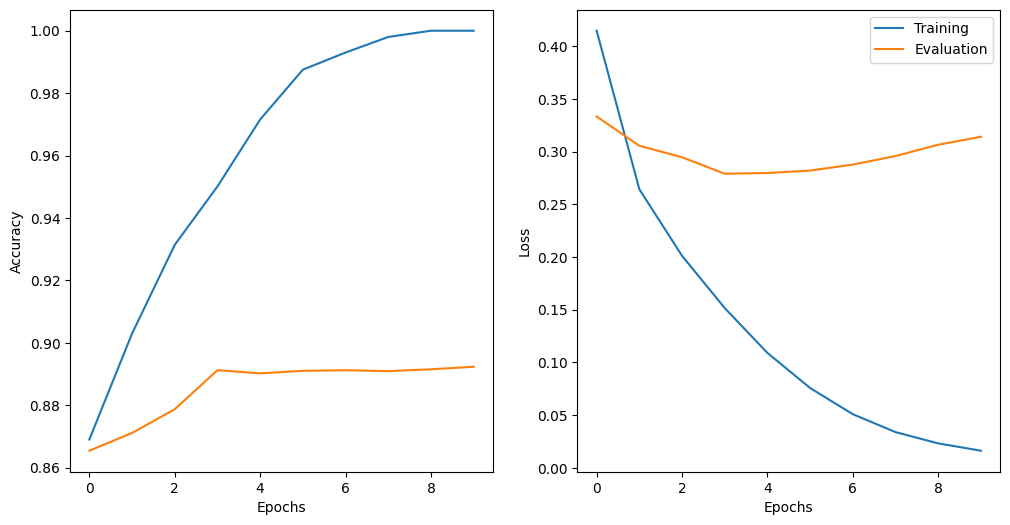

In [45]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

###**Evaluation & Prediction**

In [46]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [47]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [48]:
test_acc, test_loss = evaluate(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8942, 0.29120251451489293)

###**Inference**

In [49]:
tokenizer = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=300, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def inference(sentence, vocabulary, model):
    sentence = preprocess_text(sentence)
    encoded_sentence = vocabulary(tokenizer(sentence))
    encoded_sentence = torch.tensor(encoded_sentence)
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        predictions = model(encoded_sentence)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, yhat.item()

In [50]:
torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

In [51]:
model = load_model('./text_cnn_model.pt')
inference(test_df['preprocess_sentence'][5999], vocabulary, model)

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(99.0, 0)

In [52]:
test_df

,sentence,label,preprocess_sentence
0,Không hiểu sao mình vô và chẳng thấy hôi gì cả...,1,không hiểu sao mình vô và chẳng thấy hôi gì cả...
1,Trước mình hay ăn_ở bên nguyễn trường tộ thực_...,1,trước mình hay ăn ở bên nguyễn trường tộ thực ...
2,"Quán dễ_thương , không_gian xinh . Ngoài_ra qu...",1,quán dễ thương không gian xinh ngoài ra quán c...
3,Vào_Sài gòn chơi được thưởng_thức món ăn bắc t...,1,vào sài gòn chơi được thưởng thức món ăn bắc t...
4,"Nhà_hàng đẹp , đồ_ăn ngon , nhân_viên phục_vụ ...",1,nhà hàng đẹp đồ ăn ngon nhân viên phục vụ nhiệ...
...,...,...,...
9995,Phục_vụ cần cải_thiện hơn .\n Toàn phục_vụ cho...,0,phục vụ cần cải thiện hơn toàn phục vụ cho ngư...
9996,"Đi đã lâu , nay mới ngồi viết review . Ấn_tượn...",0,đi đã lâu nay mới ngồi viết review ấn tượng nh...
9997,Đồ_ăn ở đây thật_sự rất chán ! !\n - Gimbap nh...,0,đồ ăn ở đây thật sự rất chán gimbap nhân được ...
9998,Quán này nổi_tiếng nhất_là nướng ngói và lẩu n...,0,quán này nổi tiếng nhất là nướng ngói và lẩu n...


In [53]:
inference('Đồ ăn rất ngon và rẻ', vocabulary, model)

(79.0, 0)

In [54]:
test_df['preprocess_sentence'][5999]

'hôm bữa mình với chị mình có gé quán tối thứ mà bước vào chỉ có mình với chị mình thôi lát mới vào thêm ng nữa mình và chị gọi set cho ng bình trà kitty và loại bánh bánh thì không có cái nào ngon hết có cái thì ăn vô toàn bột k có j hết trà thì cũng ok mà phần tận k mà bánh thì quá dở phục vụ thì cũng rất nhiệt tình'